In [4]:
## tips
### do the data cleaning first
#### earliness : how early each ship has arrived at the port
#### tardiness : how late each ship has arrived at the port
#### setup time : the time between each arrival and start of operation
#### UT : time between operation end and ship disposal
#### We got two type of ships in the system, Liner and Feeder
#### 7592 records in the dataset and each row denotes to one ship
#### check iid condition for features and fit a distribution to them if needed
#### statistical indicators - goodness of fit and ....
#### partition the dataset for each ship - check if it's better to fit a single distribution to the entire dataset or it's better to fit a particular one to each ship dataset
#### more creativity means higher score
#### for more information checkout the class slide on R

In [2]:
import warnings
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from fitter import Fitter, get_common_distributions, get_distributions

In [3]:
portdata=pd.read_csv('PortData.csv')
#Drop No column
portdata=portdata.iloc[1:,:]
portdata=portdata.drop(columns={'No'})
portdata.head()


,GRT,Length,TerminalName,TEU,VoyageType,Interval,EarlinessTardiness,ST,OT,UT
1,17618.0,201,1,1861,Feeder,18.23,13,4.00,31.40,3.27
2,16694.0,174,1,1223,Liner,8.90,64,2.72,46.50,5.78
3,29873.0,210,1,605,Liner,30.38,0,1.65,25.85,4.08
4,15670.0,168,1,1502,Liner,12.00,7,4.38,56.13,5.82
5,16100.0,170,1,268,Liner,8.17,15,0.77,7.63,1.60


### data cleaning

In [4]:
portdata.isnull().sum()

GRT                   0
Length                0
TerminalName          0
TEU                   0
VoyageType            0
Interval              0
EarlinessTardiness    0
ST                    0
OT                    0
UT                    0
dtype: int64

In [5]:
Liner=portdata[portdata.VoyageType=='Liner'].reset_index(drop=True)
Feeder=portdata[portdata.VoyageType=='Feeder'].reset_index(drop=True)

In [6]:
Liner.head()

,GRT,Length,TerminalName,TEU,VoyageType,Interval,EarlinessTardiness,ST,OT,UT
0,16694.0,174,1,1223,Liner,8.90,64,2.72,46.50,5.78
1,29873.0,210,1,605,Liner,30.38,0,1.65,25.85,4.08
2,15670.0,168,1,1502,Liner,12.00,7,4.38,56.13,5.82
3,16100.0,170,1,268,Liner,8.17,15,0.77,7.63,1.60
4,36014.0,240,1,4082,Liner,14.83,0,2.22,76.73,1.93


Text(0.5, 1.0, 'Liner')

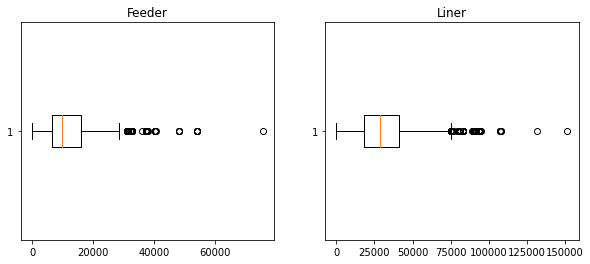

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(10,4)
ax1.boxplot(Feeder.GRT.values,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Liner.GRT,vert=False)
ax2.set_title('Liner')

In [8]:
Q1_liner = Liner['GRT'].quantile(0.25)
Q3_liner = Liner['GRT'].quantile(0.75)
IQR_liner = Q3_liner - Q1_liner    #IQR is interquartile range. 
filter1 = (Liner['GRT'] >= Q1_liner - 1.5 * IQR_liner) & (Liner['GRT'] <= Q3_liner + 1.5 *IQR_liner)
Liner_GRT=Liner.loc[filter1].GRT
Liner_GRT=Liner_GRT.reset_index(drop=True)
 ##### 
Q1_Feeder = Feeder['GRT'].quantile(0.25)
Q3_Feeder = Feeder['GRT'].quantile(0.75)
IQR_Feeder = Q3_Feeder - Q1_Feeder    #IQR is interquartile range. 
filter2 = (Feeder['GRT'] >= Q1_Feeder - 1.5 * IQR_Feeder) & (Feeder['GRT'] <= Q3_Feeder + 1.5 *IQR_Feeder)
Feeder_GRT=Feeder.loc[filter2].GRT
Feeder_GRT=Feeder_GRT.reset_index(drop=True)

In [9]:
Liner_GRT

0       16694.0
1       29873.0
2       15670.0
3       16100.0
4       36014.0
         ...   
4817    75395.0
4818    36014.0
4819    69251.0
4820    69246.0
4821    28270.0
Name: GRT, Length: 4822, dtype: float64

Text(0.5, 1.0, 'Liner')

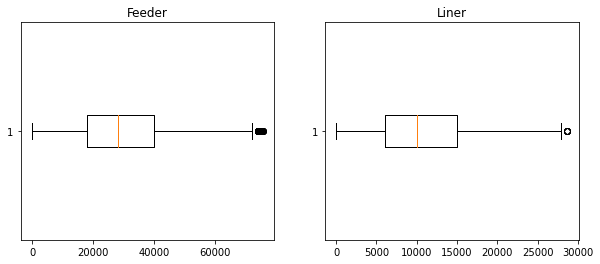

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(10,4)
ax1.boxplot(Liner_GRT,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Feeder_GRT,vert=False)
ax2.set_title('Liner')

Text(0.5, 1.0, 'Liner')

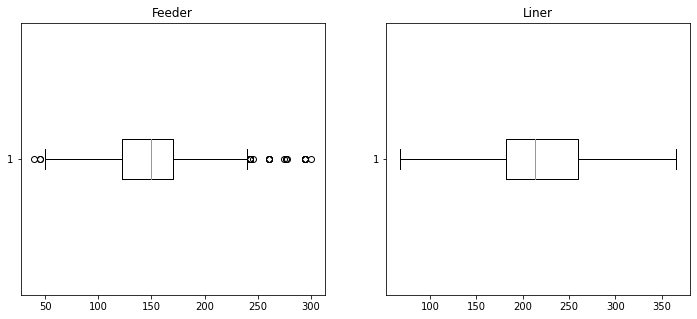

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder.Length.values,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Liner.Length,vert=False)
ax2.set_title('Liner')

In [12]:
Q1_liner = Liner['Length'].quantile(0.25)
Q3_liner = Liner['Length'].quantile(0.75)
IQR_liner = Q3_liner - Q1_liner    #IQR is interquartile range. 
filter1 = (Liner['Length'] >= Q1_liner - 1.5 * IQR_liner) & (Liner['Length'] <= Q3_liner + 1.5 *IQR_liner)
Liner_Length=Liner.loc[filter1].Length
Liner_Length=Liner_Length.reset_index(drop=True)
##### 
Q1_Feeder = Feeder['Length'].quantile(0.25)
Q3_Feeder = Feeder['Length'].quantile(0.75)
IQR_Feeder = Q3_Feeder - Q1_Feeder    #IQR is interquartile range. 
filter2 = (Feeder['Length'] >= Q1_Feeder - 1.5 * IQR_Feeder) & (Feeder['Length'] <= Q3_Feeder + 1.5 *IQR_Feeder)
Feeder_Length=Feeder.loc[filter2].Length
Feeder_Length=Feeder_Length.reset_index(drop=True)

Text(0.5, 1.0, 'Liner')

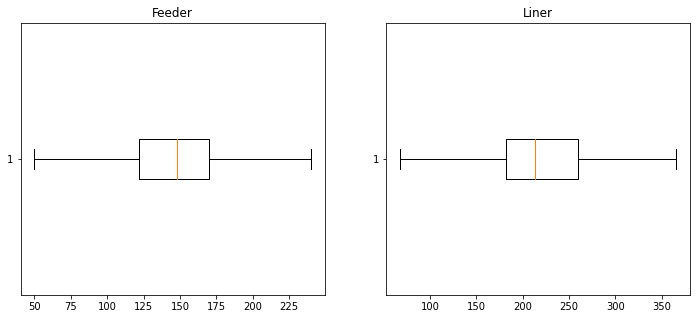

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder_Length,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Liner_Length,vert=False)
ax2.set_title('Liner')

Text(0.5, 0.98, 'TEU')

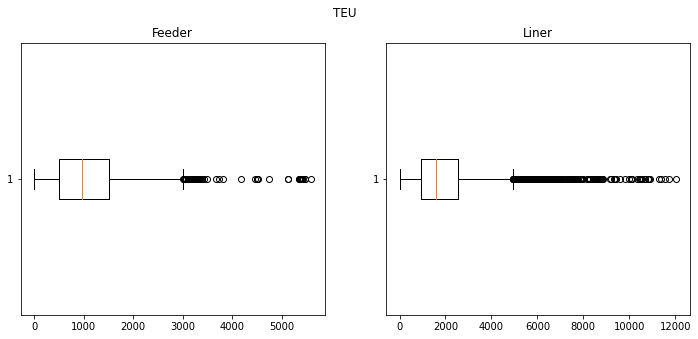

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder.TEU,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Liner.TEU,vert=False)
ax2.set_title('Liner')
fig.suptitle('TEU')

In [15]:
Q1_liner = Liner['TEU'].quantile(0.25)
Q3_liner = Liner['TEU'].quantile(0.75)
IQR_liner = Q3_liner - Q1_liner    #IQR is interquartile range. 
filter1 = (Liner['TEU'] >= Q1_liner - 1.5 * IQR_liner) & (Liner['TEU'] <= Q3_liner + 1.5 *IQR_liner)
Liner_TEU=Liner.loc[filter1].TEU
Liner_TEU=Liner_TEU.reset_index(drop=True)
##### 
Q1_Feeder = Feeder['TEU'].quantile(0.25)
Q3_Feeder = Feeder['TEU'].quantile(0.75)
IQR_Feeder = Q3_Feeder - Q1_Feeder    #IQR is interquartile range. 
filter2 = (Feeder['TEU'] >= Q1_Feeder - 1.5 * IQR_Feeder) & (Feeder['TEU'] <= Q3_Feeder + 1.5 *IQR_Feeder)
Feeder_TEU=Feeder.loc[filter2].TEU
Feeder_TEU=Feeder_TEU.reset_index(drop=True)

Text(0.5, 0.98, 'TEU')

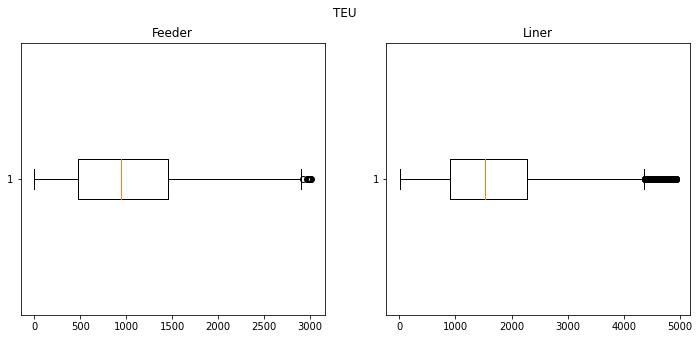

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder_TEU,vert=False,whis=1.5)
ax1.set_title('Feeder')
ax2.boxplot(Liner_TEU,vert=False,whis=1.5)
ax2.set_title('Liner')
fig.suptitle('TEU')

Text(0.5, 0.98, 'InterArrival Time')

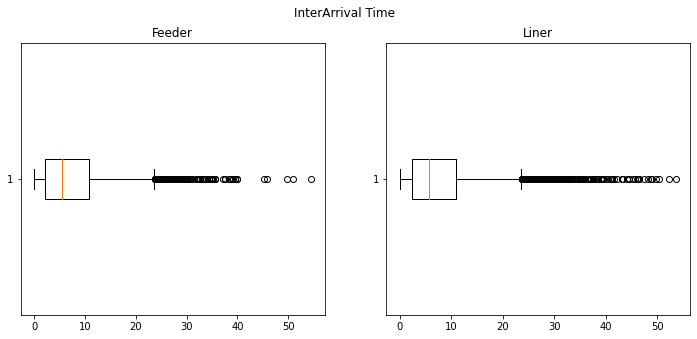

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder.Interval.values,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Liner.Interval,vert=False)
ax2.set_title('Liner')
fig.suptitle('InterArrival Time')

In [18]:
Q1_liner = Liner['Interval'].quantile(0.25)
Q3_liner = Liner['Interval'].quantile(0.75)
IQR_liner = Q3_liner - Q1_liner    #IQR is interquartile range. 
filter1 = (Liner['Interval'] >= Q1_liner - 1.5 * IQR_liner) & (Liner['Interval'] <= Q3_liner + 1.5 *IQR_liner)
Liner_arrival=Liner.loc[filter1].Interval
Liner_arrival=Liner_arrival.reset_index(drop=True)
##### 
Q1_Feeder = Feeder['Interval'].quantile(0.25)
Q3_Feeder = Feeder['Interval'].quantile(0.75)
IQR_Feeder = Q3_Feeder - Q1_Feeder    #IQR is interquartile range. 
filter2 = (Feeder['Interval'] >= Q1_Feeder - 1.5 * IQR_Feeder) & (Feeder['Interval'] <= Q3_Feeder + 1.5 *IQR_Feeder)
Feeder_arrival=Feeder.loc[filter2].Interval
Feeder_arrival=Feeder_arrival.reset_index(drop=True)

Text(0.5, 0.98, 'InterArrival Time')

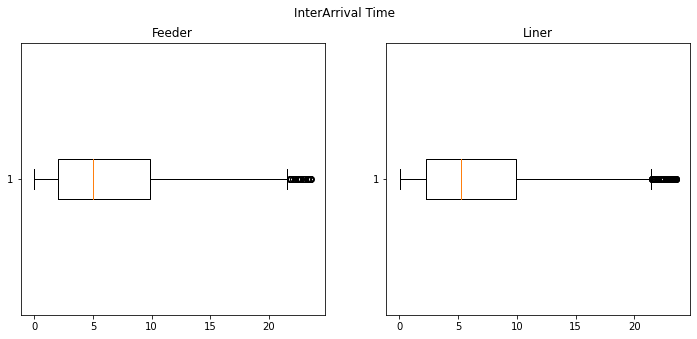

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder_arrival,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Liner_arrival,vert=False)
ax2.set_title('Liner')
fig.suptitle('InterArrival Time')

## features correlation

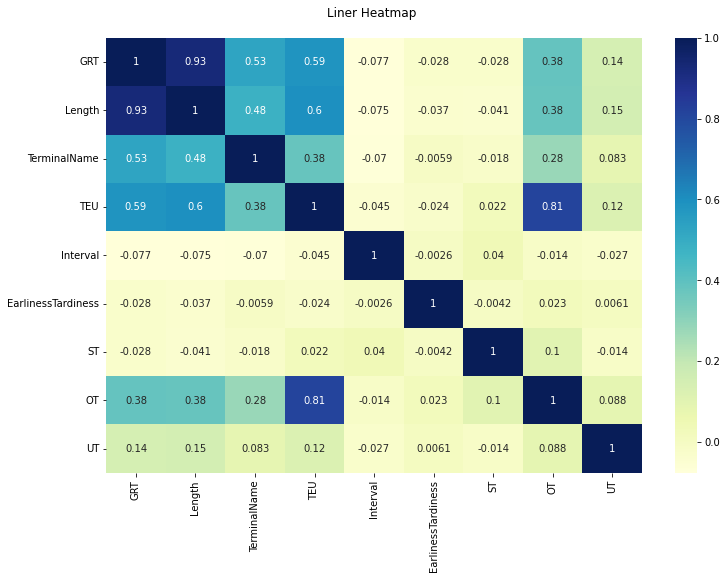

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(Liner.corr(),annot=True,cmap='YlGnBu')
plt.title('Liner Heatmap \n')
plt.show()  

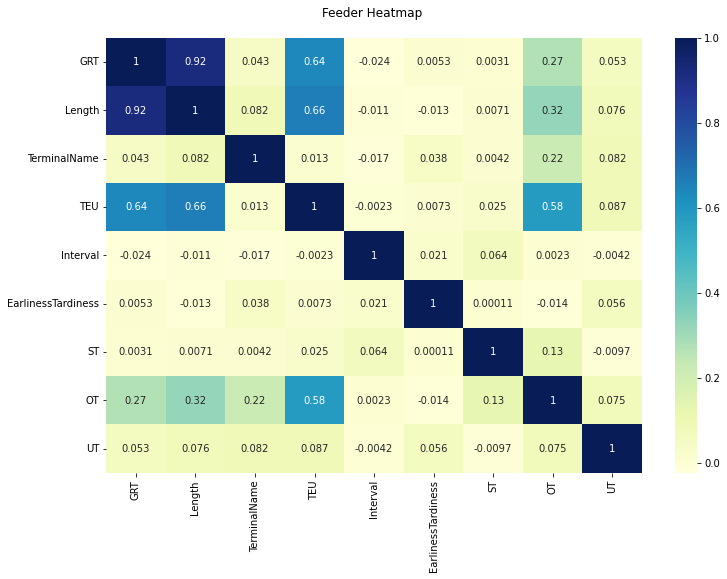

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(Feeder.corr(),annot=True,cmap='YlGnBu')
plt.title('Feeder Heatmap \n')
plt.show()  

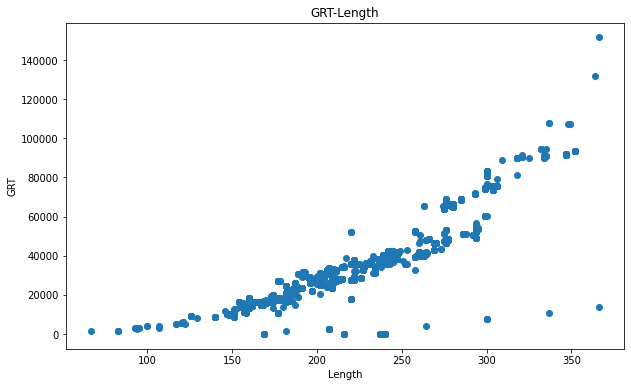

In [22]:
plt.figure(figsize=(10,6))
plt.title('GRT-Length')
plt.xlabel('Length')
plt.ylabel('GRT')
plt.plot(Liner.Length.values , Liner.GRT.values , 'o')
#plt.plot(x,y_pred,'r')

In [29]:
model = LinearRegression()
x=Liner.Length.values.reshape(-1,1)
y=Liner.GRT.values
model=model.fit(x,y)
y_pred=model.predict(x)

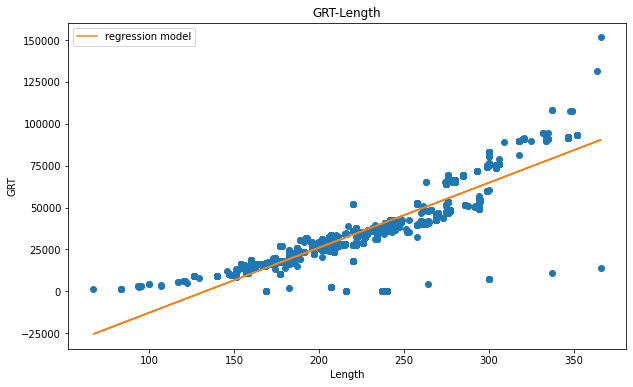

In [33]:
plt.figure(figsize=(10,6))
plt.title('GRT-Length')
plt.xlabel('Length')
plt.ylabel('GRT')
plt.plot(Liner.Length.values , Liner.GRT.values , 'o')
plt.plot(Liner.Length.values , y_pred ,label='regression model')
plt.legend()
#plt.plot(x,y_pred,'r')

In [38]:
print(model.coef_)
print(model.intercept_)

[387.76313671]
-51516.53264568703


In [40]:
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)
model2 = LinearRegression().fit(x_poly, y)
y_pred2=model2.predict(x_poly)
y_pred2

array([17230.38511004, 27180.22878205, 15939.10548144, ...,
       55226.49035639, 60034.09034804, 28179.78811605])

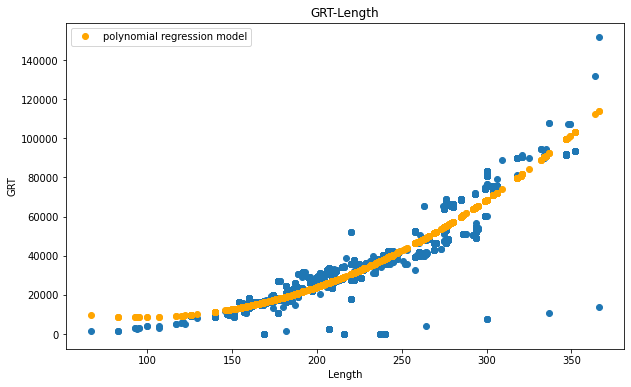

In [61]:
plt.figure(figsize=(10,6))
plt.title('GRT-Length')
plt.xlabel('Length')
plt.ylabel('GRT')
plt.plot(Liner.Length.values , Liner.GRT.values , 'o')
plt.plot(Liner.Length.values , y_pred2 ,'o',label='polynomial regression model',color='orange')
plt.legend()
#plt.plot(x,y_pred,'r')

   ## check for i.i.d

Text(0, 0.5, 'count')

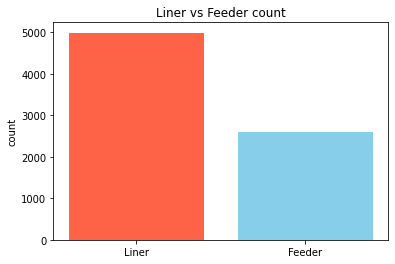

In [27]:
plt.bar(['Liner','Feeder'],[len(Liner),len(Feeder)],color=['tomato','skyblue'])
plt.title('Liner vs Feeder count')
plt.ylabel('count')

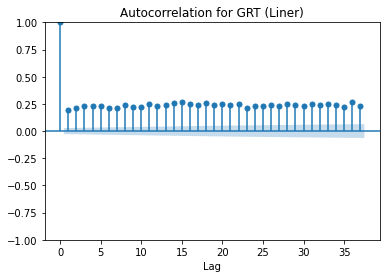

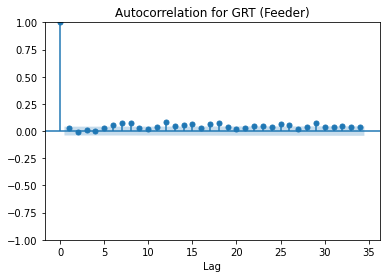

In [28]:
plot_acf(Liner_GRT)
plt.title('Autocorrelation for GRT (Liner)')
plt.xlabel('Lag')
plot_acf(Feeder_GRT)
plt.xlabel('Lag')
plt.title('Autocorrelation for GRT (Feeder)')
plt.show()

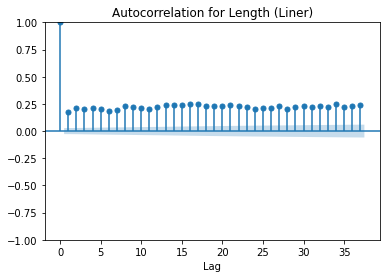

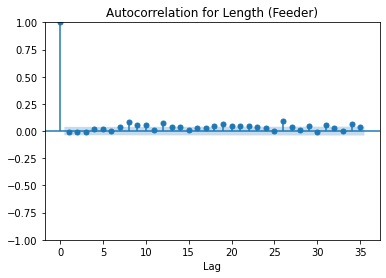

In [29]:
plot_acf(Liner_Length)
plt.title('Autocorrelation for Length (Liner)')
plt.xlabel('Lag')
plot_acf(Feeder_Length)
plt.xlabel('Lag')
plt.title('Autocorrelation for Length (Feeder)')
plt.show()

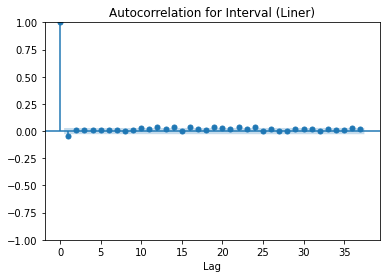

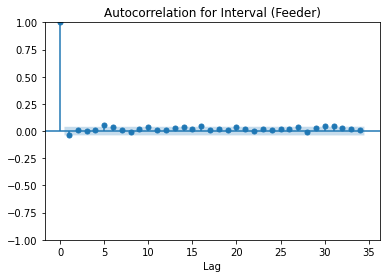

In [30]:
plot_acf(Liner_arrival)
plt.title('Autocorrelation for Interval (Liner)')
plt.xlabel('Lag')
plot_acf(Feeder_arrival)
plt.xlabel('Lag')
plt.title('Autocorrelation for Interval (Feeder)')
plt.show()

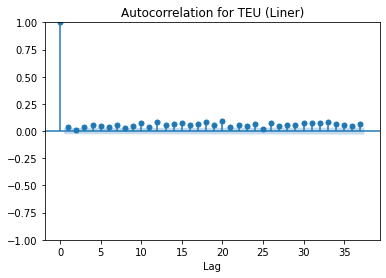

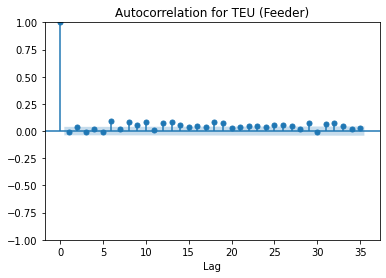

In [31]:
plot_acf(Liner_TEU)
plt.title('Autocorrelation for TEU (Liner)')
plt.xlabel('Lag')
plot_acf(Feeder_TEU)
plt.xlabel('Lag')
plt.title('Autocorrelation for TEU (Feeder)')
plt.show()

### histogram

Text(0.5, 0, 'Feeder')

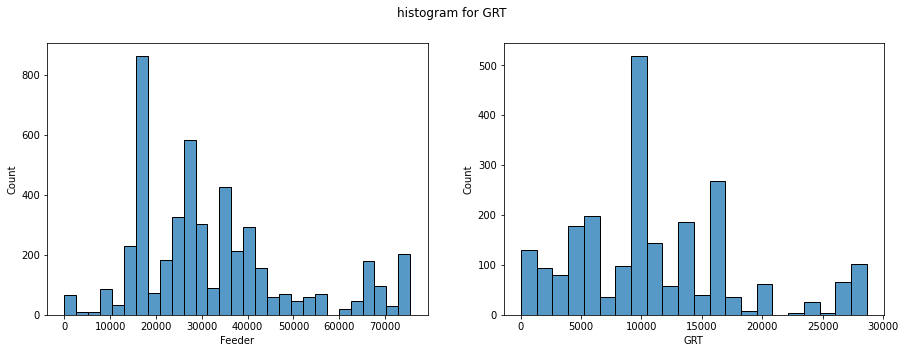

In [32]:
fig,axes=plt.subplots(1,2,figsize=(15,5))
fig.suptitle('histogram for GRT')
sns.histplot(ax=axes[0],data=Liner_GRT)
axes[0].set_xlabel('Liner')
sns.histplot(ax=axes[1],data=Feeder_GRT)
axes[0].set_xlabel('Feeder')

Text(0.5, 0, 'Feeder')

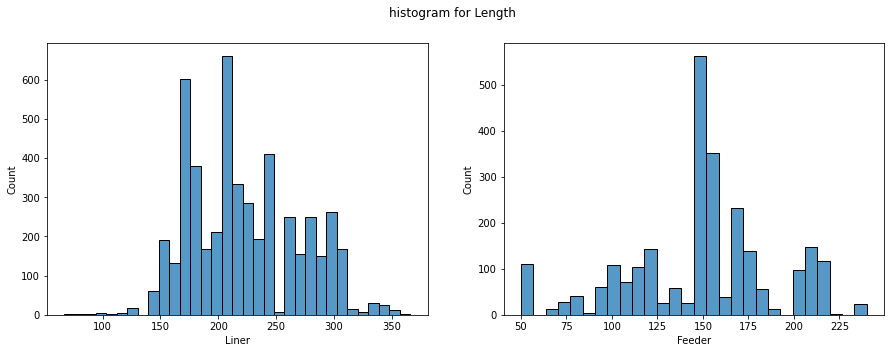

In [33]:
fig,axes=plt.subplots(1,2,figsize=(15,5))
fig.suptitle('histogram for Length')
sns.histplot(ax=axes[0],data=Liner_Length)
axes[0].set_xlabel('Liner')
sns.histplot(ax=axes[1],data=Feeder_Length)
axes[1].set_xlabel('Feeder')

Text(0.5, 0, 'Feeder')

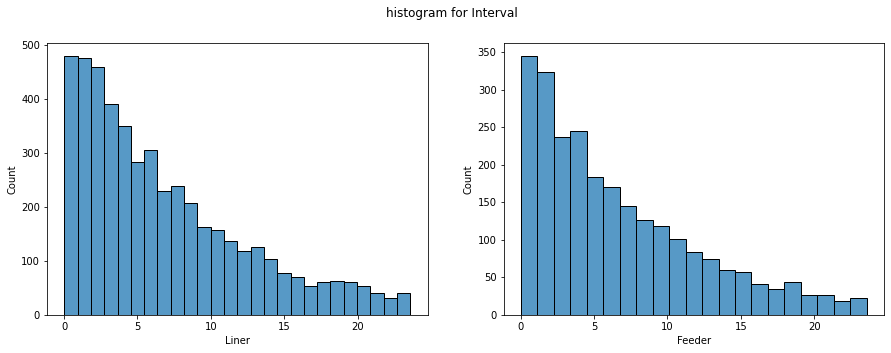

In [34]:
fig,axes=plt.subplots(1,2,figsize=(15,5))
fig.suptitle('histogram for Interval')
sns.histplot(ax=axes[0],data=Liner_arrival)
axes[0].set_xlabel('Liner')
sns.histplot(ax=axes[1],data=Feeder_arrival)
axes[1].set_xlabel('Feeder')

Text(0.5, 0, 'Feeder')

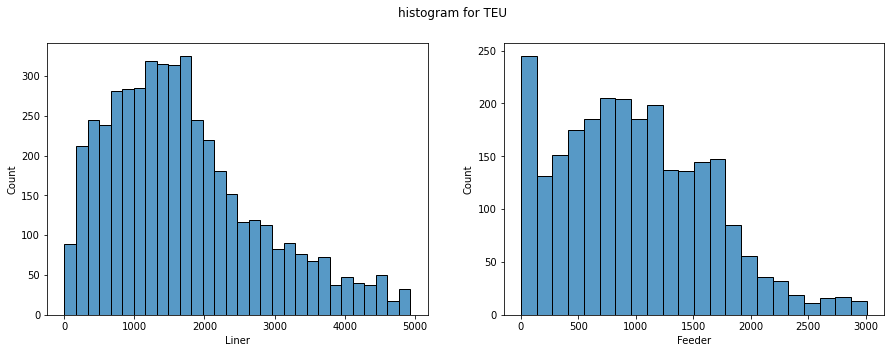

In [35]:
fig,axes=plt.subplots(1,2,figsize=(15,5))
fig.suptitle('histogram for TEU')
sns.histplot(ax=axes[0],data=Liner_TEU)
axes[0].set_xlabel('Liner')
sns.histplot(ax=axes[1],data=Feeder_TEU)
axes[1].set_xlabel('Feeder')

In [36]:
get_distributions()

['alpha',
 'anglit',
 'arcsine',
 'argus',
 'beta',
 'betaprime',
 'bradford',
 'burr',
 'burr12',
 'cauchy',
 'chi',
 'chi2',
 'cosine',
 'crystalball',
 'dgamma',
 'dweibull',
 'erlang',
 'expon',
 'exponnorm',
 'exponpow',
 'exponweib',
 'f',
 'fatiguelife',
 'fisk',
 'foldcauchy',
 'foldnorm',
 'gamma',
 'gausshyper',
 'genexpon',
 'genextreme',
 'gengamma',
 'genhalflogistic',
 'genhyperbolic',
 'geninvgauss',
 'genlogistic',
 'gennorm',
 'genpareto',
 'gilbrat',
 'gompertz',
 'gumbel_l',
 'gumbel_r',
 'halfcauchy',
 'halfgennorm',
 'halflogistic',
 'halfnorm',
 'hypsecant',
 'invgamma',
 'invgauss',
 'invweibull',
 'johnsonsb',
 'johnsonsu',
 'kappa3',
 'kappa4',
 'ksone',
 'kstwo',
 'kstwobign',
 'laplace',
 'laplace_asymmetric',
 'levy',
 'levy_l',
 'levy_stable',
 'loggamma',
 'logistic',
 'loglaplace',
 'lognorm',
 'loguniform',
 'lomax',
 'maxwell',
 'mielke',
 'moyal',
 'nakagami',
 'ncf',
 'nct',
 'ncx2',
 'norm',
 'norminvgauss',
 'pareto',
 'pearson3',
 'powerlaw',
 'pow

{'triang': {'c': 0.38524391878302167,
  'loc': -2800.8916777528693,
  'scale': 33116.39991113874}}

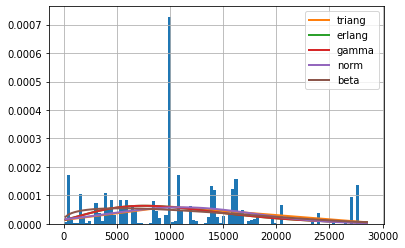

In [48]:
#Create a Fitter instance by calling the Fitter( )
#Supply the data (height) and distributions list if you have a basic idea of the distributions that might fit your data
#Apply the .fit( ) method
#Generate the fitted distribution summary using .summary( ) method
f = Fitter(Feeder_GRT,
           distributions=['gamma',
                          "beta",
                          "norm",'triang','expon','erlang'])
f.fit()
f.summary()
f.get_best()

In [41]:
#k-s chi-square goodness of fit
stats.kstest(portdata.EarlinessTardiness, stats.norm.cdf)

KstestResult(statistic=0.3513771240128273, pvalue=0.0)

In [42]:
stats.anderson(s,dist='norm')

AndersonResult(statistic=0.33584161477131147, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [43]:
#  The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals.
#  Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
#  This statistic will always be between 0 and 4.
#  The closer to 0 the statistic, the more evidence for positive serial correlation.
#  The closer to 4, the more evidence for negative serial correlation
durbin_watson(Liner.Length)

0.0709363387623054

### exporting data to text file (for arena input analyzer)

In [50]:

input_analyzer_GRT = Liner_GRT.values
path_GRT = "GRT_Liner.txt"
np.savetxt(path_GRT , input_analyzer_GRT,fmt=['%d'])

input_analyzer_GRT2 = Feeder_GRT.values
path_GRT2 = "GRT_Feeder.txt"
np.savetxt(path_GRT2 , input_analyzer_GRT2,fmt=['%d'])
#######################################################
input_analyzer_Length = Liner_Length.values
path_Length = "Length_Liner.txt"
np.savetxt(path_Length , input_analyzer_Length,fmt=['%d'])

input_analyzer_Length2 = Feeder_Length.values
path_Length2 = "Length_Feeder.txt"
np.savetxt(path_Length2 , input_analyzer_Length2,fmt=['%d'])
###########################################################
input_analyzer_arrival = Liner_arrival.values
path_arrival = "arrival_Liner.txt"
np.savetxt(path_arrival , input_analyzer_arrival,fmt=['%d'])

input_analyzer_arrival2 = Feeder_arrival.values
path_arrival2 = "arrival_Feeder.txt"
np.savetxt(path_arrival2 , input_analyzer_arrival2,fmt=['%d'])
#################################################################
input_analyzer_TEU = Liner_TEU.values
path_TEU = "TEU_Liner.txt"
np.savetxt(path_TEU , input_analyzer_TEU,fmt=['%d'])

input_analyzer_TEU2 = Feeder_TEU.values
path_TEU2 = "TEU_Feeder.txt"
np.savetxt(path_TEU2 , input_analyzer_TEU2,fmt=['%d'])